In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#imports utilizados
import numpy as np #algebra linear
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 as cv #manipulação de imagem
import requests #baixar iamgens
import matplotlib.pyplot as plt
import os
import glob
import shutil

def delete_directory(directory_path):
    """
    Deleta o diretório inteiro e todo o seu conteúdo.

    Entrada:
        - str directory_path: Caminho do diretório a ser deletado.
    """
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"O diretório '{directory_path}' foi deletado com sucesso.")
    else:
        print(f"O diretório '{directory_path}' não existe.")

delete_directory("sample_data")

# paths importantes através do código
path_to_images = "/content/drive/MyDrive/Data/*.jpg"
path_to_csv = "MovieGenre.csv"
path_to_image_dir = "/content/drive/MyDrive/Data"

O diretório 'sample_data' foi deletado com sucesso.


# Trabalho Final - Introdução ao Aprendizado de Máquina

É possível descobrir o gênero de um filme apenas pelo seu pôster? Considerando apenas pela memória, a "vibe" de um filme costuma ser retratada pelo seu pôster, aqui vamos tentar formalizar isso e tentar treinar modelos de classificação para checar se tais modelos são capazes de fazer isso também

Para esse trabalho, o dataset escolhido é constituído de 1 arquivo CSV e uma pasta com os pôsteres dos filmes, o arquivo CSV é bem simples, com apenas 6 colunas, então vamos observar quais informações podem ser tiradas dele primeiro.


# Tratando Dados Parte 1


In [ ]:
# Primeiramente, vamos carregar o arquivo csv e ver um pouco de como é a cara dele
df = pd.read_csv(path_to_csv, encoding="ISO-8859-1")

# linhas com valroes 'nan' não me interessam1

df = df.dropna()
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


Antes de começar a análise do dataframe quero verificar quais filmes já foram baixados e estão disponíveis

In [ ]:
# Quero apenas checar os filmes antes de realmente começar a manipular o df
df_test = df.copy()

sample_posters = [x.replace(".jpg", "") for x in os.listdir('SampleMoviePosters') if x.endswith('.jpg')]

df_test['imdbId'] = df_test['imdbId'].astype(str)

# Filtrando as imagens já baixadas
df_test = df_test[df_test['imdbId'].isin(sample_posters)]

In [ ]:
# Agora checando os gêneros das imagens
df_test['Genre'] = df_test['Genre'].apply(lambda x: x.split('|') if '|' in x else [x])
df_test = df_test.explode('Genre')
print(len(df_test))
df_test['Genre'].value_counts()

2266


Genre
Drama          619
Comedy         386
Romance        326
Crime          124
Short          112
Adventure       88
Mystery         64
Horror          62
Musical         58
Action          50
Family          49
Fantasy         48
Western         42
History         42
War             38
Thriller        37
Animation       30
Biography       24
Documentary     18
Sport           14
Sci-Fi          13
Film-Noir       13
Music            9
Name: count, dtype: int64

Parece que as iamgens disponibilizadas estão muito enviesadas, teremos que baixar as prórpias imagens que serão usadas para treinar a rede.

In [ ]:
#Aqui irei manipular o df para que cada filme seja classificado em apenas 1
# gênero, mas ainda representando todos os gêneros que ele poderia ser classificado

# Filtrar linhas onde 'Genre' não é uma string
df = df[df['Genre'].apply(lambda x: isinstance(x, str))]

# Dividir a coluna 'Genre' em listas
df['Genre'] = df['Genre'].apply(lambda x: x.split('|') if '|' in x else [x])

In [ ]:
# Explodir a coluna 'Genre'
df_exploded = df.explode('Genre')

# Verificar o resultado
df_exploded['Genre']

0        Animation
0        Adventure
0           Comedy
1           Action
1        Adventure
           ...    
40103        Drama
40104       Comedy
40105       Horror
40106       Action
40106       Comedy
Name: Genre, Length: 85082, dtype: object

Como queremos classificar os pôsteres nos seus respectivos gêneros, preciso extrair quantos gêneros estão disponiveis no df

In [ ]:
# Extraindo gêneros do df
genres_total = set(df_exploded["Genre"])
print(f'Portanto temos no total {len(genres_total)} gêneros no df.')
genres_total

Portanto temos no total 28 gêneros no df.


{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [ ]:
# De todos esses vou escolher os que tiverem mais informação
df_exploded['Genre'].value_counts()

Genre
Drama          19850
Comedy         12562
Romance         6188
Action          5307
Crime           5249
Thriller        4797
Horror          3981
Adventure       3806
Documentary     3556
Mystery         2387
Family          2084
Fantasy         2004
Sci-Fi          2002
Biography       1971
Animation       1704
History         1403
Music           1270
War             1162
Short            918
Western          846
Musical          837
Sport            698
Film-Noir        403
News              79
Adult              9
Talk-Show          6
Reality-TV         2
Game-Show          1
Name: count, dtype: int64

São 28 gêneros no total, mas vou escolher apenas 6 para serem classificados, o critério é que possua pelo menos 2000 filmes catalogados.

Estes foram os gêneros escolhidos:

*  Drama
*  Comedy
*  Romance
*  Action
*  Crime
* Documentary


In [4]:
selected_genres = ["Documentary", "Crime", "Action", "Romance", "Comedy", "Drama"]
print(f"No total, os filmes serão classificados em {len(selected_genres)} gêneros.")

No total, os filmes serão classificados em 6 gêneros.


In [ ]:
# Vamos limpar nosso df para conter apenas os filmes com os
# gêneros selecionados

# Seleciona as linhas que contém um gênero selecionado
df_filtered = df_exploded[df_exploded['Genre'].isin(selected_genres)]
df_filtered = df_filtered.dropna()
df_filtered.groupby(['imdbId','Title'])['Genre'].apply('|'.join)

imdbId   Title                                             
3        Pauvre Pierrot (1892)                                         Comedy
8        Edison Kinetoscopic Record of a Sneeze (1894)            Documentary
12       The Arrival of a Train (1896)                            Documentary
14       Tables Turned on the Gardener (1895)                          Comedy
439      The Great Train Robbery (1903)                          Action|Crime
                                                                    ...      
6041048  Autumn in the Vineyard (2016)                         Comedy|Romance
6047684  Signed, Sealed, Delivered: Lost Without You (2016)             Drama
6071534  Gringo: The Dangerous Life of John McAfee (2016)         Documentary
6081882  Iliza Shlesinger: Confirmed Kills (2016)                      Comedy
6098922  Louis Theroux: Savile (2016)                             Documentary
Name: Genre, Length: 34074, dtype: object

# Tratando Dados Parte 2
Finalmente com o df devidamente tratado para representar nossos desejos, posso começar a baixar as imagens

In [ ]:
# cria pastas designadas para cada gênero
os.makedirs(path_to_image_dir, exist_ok=True)
for g in selected_genres:
    os.makedirs(f"{path_to_image_dir}/{g}", exist_ok=True)

In [ ]:
def get_img_baixadas(path_to_image_dir):
    """Obtém os IDs das imagens já baixadas em todos os subdiretórios."""
    ids_baixadas = []

    for root, _, files in os.walk(path_to_image_dir):
        for f in files:
            if f.endswith(".jpg"):
                image_id = os.path.splitext(f)[0].replace(".jpg", "")
                ids_baixadas.append(image_id)

    return ids_baixadas

In [ ]:
get_img_baixadas(path_to_image_dir)

[]

In [ ]:
def baixar_imagens(df, genre, path_to_image_dir, image_limit=2000):
    """
    Baixa imagens de um DataFrame filtrado por gênero, evitando duplicatas em diretórios irmãos.

    Entrada:
        - df: dataframe com os links utilizados
        - genre: gênero desejado
        - path_to_image_dir: diretório onde as imagens serão baixadas
        - image_limit: número máximo de imagens a serem baixadas
    """
    # Filtrar DataFrame apenas com as colunas de interesse
    filtered_df = df[df['Genre'] == genre]

    # Ids das imagens já baixadas em todos os subdiretórios
    down_imgs = get_img_baixadas(path_to_image_dir)

    # Diretório específico para o gênero
    genre_directory = os.path.join(path_to_image_dir, genre)
    if not os.path.exists(genre_directory): # se diretório não existe -> erro
        raise ValueError(f"O diretório {genre_directory} não existe.")

    # Contador para o número de imagens baixadas
    image_count = len(os.listdir(genre_directory))
    print("Baixando para:", genre_directory, image_count, "já baixadas")

    # Iterar sobre as linhas filtradas do DataFrame
    for index, row in filtered_df.iterrows():
        image_url = row['Poster']
        image_id = str(row['imdbId'])

        if image_count % 200 == 0:  # Apenas checando o andamento
            print("    Baixadas até o momento:", image_count)

        # Se já baixei o suficiente -> break
        if image_count >= image_limit:
            break

        # Verificar se a imagem já foi baixada (baseado em ID)
        if image_id in down_imgs:
            continue

        # Caminho onde o arquivo será guardado
        file_path = os.path.join(genre_directory, f"{image_id}.jpg")

        # Baixando posters
        try:
            response = requests.get(image_url, stream=True)
            if response.status_code == 200:
                # Salva a imagem no diretório especificado
                with open(file_path, 'wb') as file:
                    for chunk in response.iter_content(1024):
                        file.write(chunk)

                # Adiciona o ID da imagem baixada ao conjunto
                down_imgs.append(image_id)

                # Só conta depois da imagem ser baixada
                image_count += 1
            else:
                continue
        except Exception as e:
            continue
    print()

In [ ]:
df_filtered[df_filtered['Genre'] == 'Comedy']

NameError: name 'genre' is not defined

In [ ]:
#Baixando imagens...
for g in selected_genres:
    baixar_imagens(df_filtered, g, path_to_image_dir, image_limit=2000)

Baixando para: /content/drive/MyDrive/Data/Documentary 0 já baixadas
    Baixadas até o momento: 0
    Baixadas até o momento: 200
    Baixadas até o momento: 400
    Baixadas até o momento: 600
    Baixadas até o momento: 800
    Baixadas até o momento: 1000
    Baixadas até o momento: 1200
    Baixadas até o momento: 1400
    Baixadas até o momento: 1600
    Baixadas até o momento: 1800
    Baixadas até o momento: 2000

Baixando para: /content/drive/MyDrive/Data/Crime 0 já baixadas
    Baixadas até o momento: 0
    Baixadas até o momento: 200
    Baixadas até o momento: 400
    Baixadas até o momento: 600
    Baixadas até o momento: 800
    Baixadas até o momento: 1000
    Baixadas até o momento: 1200
    Baixadas até o momento: 1200
    Baixadas até o momento: 1400
    Baixadas até o momento: 1400
    Baixadas até o momento: 1600
    Baixadas até o momento: 1800
    Baixadas até o momento: 2000

Baixando para: /content/drive/MyDrive/Data/Action 0 já baixadas
    Baixadas até o momen

In [ ]:
def verificar_duplicatas(path_to_image_dir):
    """
    Verifica se há imagens duplicadas em subdiretórios diferentes.

    Entrada:
        - path_to_image_dir: diretório onde as imagens estão localizadas
    """
    img_to_dirs = {}

    for root, _, files in os.walk(path_to_image_dir):
        for file in files:
            if file.endswith(".jpg"):
                image_id = os.path.splitext(file)[0]
                if image_id in img_to_dirs:
                    img_to_dirs[image_id].append(root)
                else:
                    img_to_dirs[image_id] = [root]

    duplicatas = {img_id: dirs for img_id, dirs in img_to_dirs.items() if len(dirs) > 1}

    if duplicatas:
        for img_id, dirs in duplicatas.items():
            print(f"Imagem ID {img_id} encontrada nos diretórios: {dirs}")
    else:
        print("Nenhuma imagem duplicada encontrada.")

In [ ]:
verificar_duplicatas(path_to_image_dir)

Nenhuma imagem duplicada encontrada.


In [ ]:
# Agora preciso checar se a função anterior baixou a quantidade certa de imagens
def checar_qnt_imagens(dir:str):
    contadores = {}

    for genre in selected_genres:
        genre_dir = os.path.join(dir, genre)

        # Contar quantos arquivos de imagem existem no diretório
        num_imagens = len([f for f in os.listdir(genre_dir) if f.endswith(".jpg")])

        # Armazenar informação
        contadores[genre] = num_imagens

    return contadores

In [ ]:
check = checar_qnt_imagens(path_to_image_dir)
print("Imagens dentro de cada diretório:", check)
print("Imagens total:", sum(check.values()))

Imagens dentro de cada diretório: {'Documentary': 2000, 'Crime': 2000, 'Action': 2000, 'Romance': 2000, 'Comedy': 2000, 'Drama': 2000}
Imagens total: 12000


Agora nosso dataset está bem balanceado, vamos separá-lo em treino/validação e teste e carregá-lo para dentro do código usando tensorflow e keras

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [6]:
# Define os caminhos
data = '/content/drive/MyDrive/Data_Separated'
train_dir = data + '/Train'
val_dir = data + '/Validation'
test_dir = data + '/Test'

In [ ]:
# Célula para separar conjunto de dados em treino/validação/teste

# Crie as pastas de treino, validação e teste se não existirem
for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Obtenha a lista de classes
classes = selected_genres.copy()

# Define a proporção dos conjuntos
# Treino 70%; Validação 15%; Teste 15%
test_size = 0.15
val_size = 0.15 / (1 - test_size)  # Proporção de validação em relação ao conjunto de treino+validação

for cls in classes:
    cls_dir = os.path.join(path_to_image_dir, cls)

    # Crie diretórios de classe para treino, validação e teste
    cls_train_dir = os.path.join(train_dir, cls)
    cls_val_dir = os.path.join(val_dir, cls)
    cls_test_dir = os.path.join(test_dir, cls)

    for dir_path in [cls_train_dir, cls_val_dir, cls_test_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

    # Liste todas as imagens da classe
    images = os.listdir(cls_dir)
    images = [img for img in images if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Divida em treino+validação e teste
    train_val_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42, stratify=[cls]*len(images))

    # Divida treino+validação em treino e validação
    train_imgs, val_imgs = train_test_split(train_val_imgs, test_size=val_size, random_state=42, stratify=[cls]*len(train_val_imgs))

    # Mova as imagens para os diretórios apropriados
    for img in train_imgs:
        shutil.copy2(os.path.join(cls_dir, img), os.path.join(cls_train_dir, img))
    for img in val_imgs:
        shutil.copy2(os.path.join(cls_dir, img), os.path.join(cls_val_dir, img))
    for img in test_imgs:
        shutil.copy2(os.path.join(cls_dir, img), os.path.join(cls_test_dir, img))


In [7]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [8]:
# Separa imagens em treino e validação, também faz resize nas imagens
# e aplica camadas de augmentação de dados

train_generator= datagen.flow_from_directory(train_dir,
                                              target_size=(180, 180),
                                              batch_size=32,
                                              class_mode='categorical')

val_generator = datagen.flow_from_directory(val_dir,
                                            target_size=(180, 180),
                                            batch_size=32,
                                            class_mode='categorical')

test_generator = datagen.flow_from_directory(test_dir,
                                            target_size=(180, 180),
                                            batch_size=32,
                                            class_mode='categorical')


Found 8400 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.


In [9]:
class_names = train_generator.class_indices
print(class_names)

{'Action': 0, 'Comedy': 1, 'Crime': 2, 'Documentary': 3, 'Drama': 4, 'Romance': 5}


# Modelos de Classificação
Como foi pedido na descrição do trabalho, haverão 2 modelos de classificação abrangidos aqui. O primeiro será uma rede neural e o segundo um modelo de floresta aleatória

## Rede Neural - Modelo 1

In [18]:
# imports para criar a rede
from keras.models import Sequential
from keras.layers import Rescaling, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [11]:
# Cria rede
model_nn = Sequential()

# Camada de entrada
model_nn.add(Rescaling(1./255, input_shape=(180, 180, 3)))

# Camada convolucional 1
model_nn.add(Conv2D(64, (3, 3), activation='relu'))
model_nn.add(MaxPooling2D())

# Camada convolucional 2
model_nn.add(Conv2D(32, (3, 3), activation='relu'))
model_nn.add(MaxPooling2D())

# Camada convolucional 3
model_nn.add(Conv2D(32, (3, 3), activation='relu'))
model_nn.add(MaxPooling2D())

# Flatten para conectar às camadas densas
model_nn.add(Flatten())

# Camada densa 1
model_nn.add(Dense(64, activation='relu'))

# Dropout para prevenir overfitting
model_nn.add(Dropout(0.4))

# Camada densa 2
model_nn.add(Dense(32, activation='relu'))

# Camada de saída
model_nn.add(Dense(len(class_names), activation='softmax'))

# Compilação do modelo
model_nn.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [13]:
model_nn.load_weights('Pesos-Final-Teste35')

In [ ]:
hist = model_nn.fit(train_generator, validation_data=val_generator, epochs=35)

In [ ]:
model_nn.save('Pesos-Final-Teste35', save_format='tf')

57/57 [==============================] - 137s 2s/step


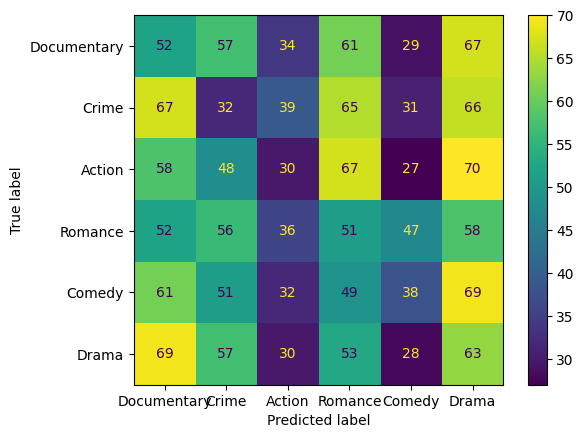

In [15]:
# Matriz de confusão
Y_pred = model_nn.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_genres)
disp.plot()

In [29]:
certos = 0
for i in range(len(cm)):
    certos += cm[i][i]
print(f'Acurácia: {certos / np.sum(cm)}')

print(classification_report(test_generator.classes, y_pred, target_names=selected_genres))

Acurácia: 0.14777777777777779
              precision    recall  f1-score   support

 Documentary       0.14      0.17      0.16       300
       Crime       0.11      0.11      0.11       300
      Action       0.15      0.10      0.12       300
     Romance       0.15      0.17      0.16       300
      Comedy       0.19      0.13      0.15       300
       Drama       0.16      0.21      0.18       300

    accuracy                           0.15      1800
   macro avg       0.15      0.15      0.15      1800
weighted avg       0.15      0.15      0.15      1800



## Floresta Aleatória - Modelo 2

In [ ]:
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Função para extrair características HOG de uma imagem colorida
def extract_hog_features(image_path):
    image = cv.imread(image_path)
    resized_img = cv.resize(image, (180, 180))
    hog_features = []

    for channel in range(resized_img.shape[2]):  # Para cada canal de cor (R, G, B)
        channel_features, _ = hog(resized_img[:, :, channel], orientations=8, pixels_per_cell=(16, 16),
                                  cells_per_block=(1, 1), visualize=True)
        hog_features.extend(channel_features)

    return hog_features

In [ ]:
X = []
y = []

# Extraindo características HOG e rótulos
for genre in selected_genres:
    genre_dir = os.path.join(path_to_image_dir, genre)

    for img_file in os.listdir(genre_dir):
        img_path = os.path.join(genre_dir, img_file)
        features = extract_hog_features(img_path)
        X.append(features)
        y.append(selected_genres.index(genre))

X = np.array(X)
y = np.array(y)

In [ ]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Treinando o Random Forest
model_rf = RandomForestClassifier(n_estimators=1000,
                                  random_state=42,
                                  criterion='entropy',
                                  n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [ ]:
# Prevendo e avaliando
y_pred = model_rf.predict(X_test)
print(f'Acurácia: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=selected_genres))

Acurácia: 0.24222222222222223
              precision    recall  f1-score   support

 Documentary       0.28      0.31      0.30       604
       Crime       0.26      0.20      0.23       610
      Action       0.26      0.50      0.35       613
     Romance       0.17      0.18      0.17       567
      Comedy       0.21      0.15      0.18       597
       Drama       0.22      0.10      0.14       609

    accuracy                           0.24      3600
   macro avg       0.24      0.24      0.23      3600
weighted avg       0.24      0.24      0.23      3600



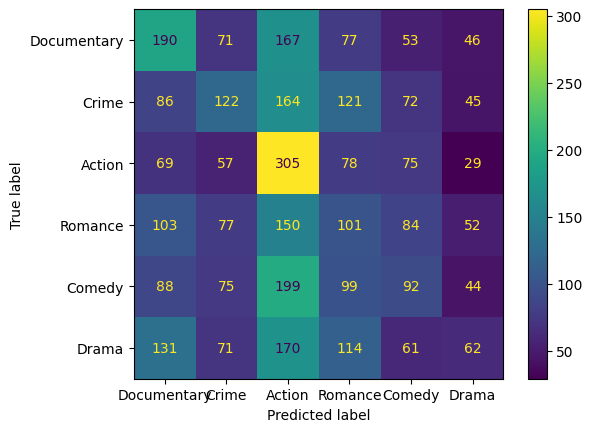

In [ ]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_genres)
disp.plot()

# Conclusão
Pelo menos para o dataset escolhido e as imagens utilizadas, a conclusão é que não é possível inferir o gênero de um filme apenas pelo pôster dele. A esperança é que certos filmes tivessem características em comum, por exemplo: filmes de romance teriam duas pessoas juntas e filmes de crime teriam alguma arma e cores mais escuras. Acreito que o problema é que (obviamente) isso não é uma regra, além disso há um fator temporal a ser considerado também, um pôster de um filme de Drama nos dias de hoje segue os mesmos princípios de design de 20/30/40 anos atrás? No final, os modelos utilizados performaram abaixo do esperado e como conclusão, não seria possível prever o gênero de um filme.